# Calibration of implied volatility's surfaces with the SABR model
### *Objective*: To calibrate the SABR parameters to get the implied volatilities when pricing vanilla instruments. 
The SABR model modelizes the implied volatility's smile for vanilla instruments such as caplets/floorlets and their corresponding caps/floors, and swaptions.  
To get a correct modelization of the implied volatility's smiles, the SABR model is to be calibrated through actual market swaptions with their own implied volatility.    

### *Main used notions*:     
- Hagan's SABR formula 
- Mean Squared Error (MSE) to measure the quality of an estimation
- Minimization of the errors to identify the best SABR parameters    

### *General structure of following script*: 
1. Calculation of the implied volatility using the SABR model.   
2. Estimation of the quality of the calculated implied volatility through the mean squared error method.    
3. Identification of the most fitting SABR parameters to calculate the imply volatility.   
4. Handling of the SABR calibration for each "maturity - tenor" combination.   
5. Plotting of the volatility's smile calculated throught the calibrated SABR model, for each "maturity - tenor" combination.
6. Print the SABR parameters for using them in pricing of fixed-income instruments. 

In [564]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps

## Calculate implied volatilities from the SABR model.

The SABR model generates smiles of volatility close enough of volatilities observed in the market.  
In this project the market volatilities are Black volatilities (i.e. volatilities calculated with the Black model).

The SABR implied volatility depends on :    
- $F$ : forward of the underlying
- $K$ : strike of the option

$\sigma_{SABR}(F, K) = \frac{\alpha}{(F K)^{\frac{1-\beta}{2}} \Big(1 + \frac{(1-\beta)^2}{24} (\ln \tfrac{F}{K})^2 + \frac{(1-\beta)^4}{1920} (\ln \tfrac{F}{K})^4 \Big)} \cdot \frac{z}{x(z)} \cdot \Bigg[ 1 + \Big( \frac{(1-\beta)^2}{24} \frac{\alpha^2}{(F K)^{1-\beta}} \frac{\rho \beta \nu \alpha}{4 (F K)^{\frac{1-\beta}{2}}} \frac{2 - 3 \rho^2}{24} \nu^2 \Big) T \Bigg] $

*avec* :   
$z = \frac{\nu}{\alpha} (F K)^{\frac{1-\beta}{2}} \ln \frac{F}{K}$  

$x(z) = \ln \left( \frac{ \sqrt{1 - 2 \rho z + z^2} + z - \rho }{1 - \rho} \right)$ 

*Particular case $ \Rightarrow $ when K = F (ATM)* :

$\sigma_{SABR}(F, K) = \frac{\alpha}{(F K)^{\frac{1-\beta}{2}} \Big(1 + \frac{(1-\beta)^2}{24} (\ln \tfrac{F}{K})^2 + \frac{(1-\beta)^4}{1920} (\ln \tfrac{F}{K})^4 \Big)} \cdot \Bigg[ 1 + \Big( \frac{(1-\beta)^2}{24} \frac{\alpha^2}{(F K)^{1-\beta}} \frac{\rho \beta \nu \alpha}{4 (F K)^{\frac{1-\beta}{2}}} \frac{2 - 3 \rho^2}{24} \nu^2 \Big) T \Bigg] $

*where* SABR parameters are :
- $\alpha$ : initial volatility of the forward 
- $\beta$ : elasticity ($\beta = 1$ for lognormal i.e. Black ; $\beta = 0$ for normal ; $0 < \beta < 1$ as intermediary)
- $\rho$ : forward/volatility correlation to control the asymetry of the smile of volatility
- $\nu$ : volatility of the volatility (vol-vol) to control the curvature of the smile of volatility

For an option's maturity and a swap's tenor defining the swaption, we have a smile of volatility (implied volatility function of the strike) with its defining SABR parameters. 

In [565]:
def sabr_implied_vol(F, K, T, alpha, beta, rho, nu, shift):
    """
    Calculate the SABR volatility for given parameters.
    """
    K = np.array(K, dtype=float)
    F = F + shift
    K = K + shift
    
    eps = 1e-07
    logfk = np.log(F / K)
    fkbeta = (F*K)**(1 - beta)
    a = (1 - beta)**2 * alpha**2 / (24 * fkbeta)
    b = 0.25 * rho * beta * nu * alpha / fkbeta**0.5
    c = (2 - 3*rho**2) * nu**2 / 24.
    d = fkbeta**0.5
    v = (1 - beta)**2 * logfk**2 / 24
    w = (1 - beta)**4 * logfk**4 / 1920
    z = nu * fkbeta**0.5 * logfk / alpha
    tmp = alpha * (1 + (a + b + c) * T)
    num = np.where(abs(z) > eps, z * tmp, tmp)
    den = np.where(abs(z) > eps, (d * (1 + v + w) * _x(rho, z)), d * (1 + v + w))
    return num / den

def _x(rho, z):
    a = (1 - 2*rho*z + z**2)**0.5 + z - rho
    b = 1 - rho
    return np.log(a / b) 

## Estimate the quality of the calculated implied volatility.  

$\text{MSE}(\hat\sigma^2) = \frac{1}{N}\sum_i (\sigma_{\text{SABR}}(K_i) - \sigma_{\text{mkt}}(K_i))^2$

We calculate the difference between a range of SABR's implied volatilities and the market implied volatilities for a given "maturity - tenor" combination, through the mean squared error method.       
The SABR volatilities the closest to the market volatilities, means their SABR parameters are those to get the best calibration of the SABR model (see below).    

In [566]:
def sabr_loss(alpha, rho, nu, F, T, Ks, sigmas_mkt, beta, shift):
    """
    Calculate the MSE between the SABR volatilities and market volatilities for a set of unique values "alpha, rho, nu"
    """
    sigmas_model = sabr_implied_vol(F, Ks, T, alpha, beta, rho, nu, shift)
    diff = sigmas_model - sigmas_mkt
    return float(np.mean(diff * diff))

## Identify the most fitting SABR parameters to calculate the imply volatility. 

### Identify the SABR parameters to be tested in the calibration
In order to identify the SABR parameters, first we need a range of values for each parameter where we do the search.    
These ranges are chosen from empirical observations in the market.      

1. Initial volatility $\alpha$      
The initial volatility directly depends on the ATM volatility $\Rightarrow α ≈ \sigma_{\text{ATM}}  × F^{1−β}$      
To cover sufficient values of $\alpha$, a large enough standard deviation within the previously range of values, has to be chosen.  
The search of samples is performed on a log-normal scale, as the volatility is positive only and its influence on implied volatility is multiplicative.   
So the use of the log-normal scale is more efficient on finding the best candidates for the initial volatility.    

2. Correlation $\rho$            
The search of samples related to an optimal correlation is performed on a linear scale, as the correlation can be both postive or negative.        
Moreover the influence of the correlation on the implied volatility is additive.  

3. Volatility of the volatility (vol-vol) $\nu$        
The search of samples related to an optimal vol-vol is performed on a log-normal scale, as the vol-vol is positive only.          
The influence of the vol-vol on the implied volatility is multiplicative. 

### Measure and select the best estimates
Using the MSE method (see above) to measure how far an estimation is from its target, we select the SABR parameters' estimations where MSE values are the lowest.    

### Optimize the estimates
After getting the best estimations from the samples, we search all around them for better fitting SABR parameters' estimations, within a smaller ranges of new samples.    

P.S. To identify the best fitting SABR parameters, we could have used the scipy function *scipy.optimize.minimize* minimizing the difference between both set of volatilities.          
This function covers both steps *Measure and select the best estimates* and *Optimize the estimates*.  

In [567]:
def calibrate_sabr_slice(F, T, Ks, sigmas_mkt,
                         beta, shift, n_global, n_local):
    """
    Calibrate the SABR parameters (alpha, rho, nu) for an option's maturity and swap's tenor, from market volatility
    """
    Ks = np.array(Ks, dtype = float)
    sigmas_mkt = np.array(sigmas_mkt, dtype = float)

    # Limits of the SABR parameters
    alpha_lo, alpha_hi = 1e-4, 0.2
    rho_lo, rho_hi = -0.999, 0.999
    nu_lo, nu_hi = 1e-4, 3.0

    # Initialisation through ATM vol
    atm_idx = int(np.argmin(np.abs(Ks - F)))
    sigma_atm = float(sigmas_mkt[atm_idx])

    alpha_guess = sigma_atm * (F + shift)**(1.0 - beta)
    alpha_guess = float(np.clip(alpha_guess, alpha_lo, alpha_hi))

    # ----------- Identification of sets of log-normal alpha's and nu's values, and uniform rho's values
    alpha_samples = np.exp(np.log(alpha_guess) + np.random.normal(0.0, 0.7, size=n_global))
    alpha_samples = np.clip(alpha_samples, alpha_lo, alpha_hi)
    
    rho_samples = np.random.uniform(rho_lo, rho_hi, size=n_global)

    nu_samples = np.exp(np.log(0.5) + np.random.normal(0.0, 0.8, size=n_global))
    nu_samples = np.clip(nu_samples, nu_lo, nu_hi)

    # -- Identification of the best combination (alpha, rho, nu) minimizing the difference between SABR volatility and market volatility
    losses = np.empty(n_global, dtype=float)
    for i in range(n_global):
        losses[i] = sabr_loss(alpha_samples[i], 
                              rho_samples[i],
                              nu_samples[i], 
                              F, T, Ks, sigmas_mkt, beta, shift)
        
    best_idx = int(np.argmin(losses))    
    alpha_best = float(alpha_samples[best_idx])
    rho_best = float(rho_samples[best_idx])
    nu_best = float(nu_samples[best_idx])
    best_loss = float(losses[best_idx])

    # -- Identification of a possible better combination around the best combination (alpha, rho, nu) so far
    for _ in range(n_local):
        alpha_prop = alpha_best * np.exp(np.random.normal(0.0, 0.2))
        alpha_prop = float(np.clip(alpha_prop, alpha_lo, alpha_hi))

        rho_prop = rho_best * np.random.normal(0.0, 0.05)
        rho_prop = float(np.clip(rho_prop, rho_lo, rho_hi))

        nu_prop = nu_best * np.exp(np.random.normal(0.0, 0.25))
        nu_prop = float(np.clip(nu_prop, nu_lo, nu_hi))

        L = sabr_loss(alpha_prop, rho_prop, nu_prop,
                      F, T, Ks, sigmas_mkt, beta, shift)
        
        if L < best_loss:
            alpha_best, rho_best, nu_best, best_loss = alpha_prop, rho_prop, nu_prop, L

    return alpha_best, rho_best, nu_best, best_loss

## Manage the SABR calibration for each "maturity - tenor" combination.  
From a set of market swaptions' implied volatilities we identify the SABR parameters for which the calculated SABR volatilities are as close as possible.  
Thanks to the identified SABR parameters, we calculate back the SABR implied volatilities.

As a reminder, the SABR volatilities are calculated from the SABR parameters, the forward and the strike.  
And the SABR parameters to be found, depend on the option's maturity and swap's tenor.  

In [ ]:
def calibrate_sabr_surface(mkt_swpt_vol,
                    beta,
                    shift,
                    n_global=3000,          # number of samples searched on a larger scale
                    n_local=500):           # number of samples searched on a smaller scale

    results = []
    SABR_vols_rows = []

    for (T_opt, T_swap), sub in mkt_swpt_vol.groupby(["option_maturity", "swap_tenor"]):
        sub = sub.sort_values("strike")
        Ks = np.array(sub["strike"])
        sigmas_mkt = np.array(sub["vol_black"])

        F = float(sub["forward"].iloc[0])
        T = float(T_opt)

        alpha_hat, rho_hat, nu_hat, mse = calibrate_sabr_slice(
                                            F, T, Ks, sigmas_mkt,
                                            beta, shift, n_global, n_local)
        
        results.append({
            "option_maturity": T_opt,
            "swap_tenor": T_swap,
            "forward": F,
            "beta": beta,
            "shift": shift,
            "alpha": alpha_hat,
            "rho": rho_hat,
            "nu": nu_hat,
            "mse": mse})
        
        # Calculation of the SABR volatilities for a given option's maturity and swap's tenor
        sigmas_SABR = sabr_implied_vol(F, Ks, T, alpha_hat, beta, rho_hat, nu_hat, shift)
        tmp = sub.copy()
        tmp["vols_SABR"] = sigmas_SABR
        SABR_vols_rows.append(tmp)

    SABR_params = pd.DataFrame(results)
    SABR_vols = pd.concat(SABR_vols_rows)

    return SABR_params, SABR_vols

### Plot each smile of volatility per couple option's maturity - swap's tenor.   

In [569]:
def plot_sabr_vol_smile(SABR_vols):

    plt.figure(figsize=(15,8))

    # List of groups, used later on to manage SABR volatility's curve et market volatility points with same color
    groups = list(SABR_vols.groupby(["option_maturity", "swap_tenor"]))
    n = len(groups)

    # Range of colors
    cmap = colormaps["tab10"] if n <= 10 else colormaps["tab20"]
    colors = cmap(np.linspace(0, 1, n))

    for i, ((T_opt, T_swap), slice) in enumerate(groups):
        slice = slice.sort_values("strike")
        color = cmap(i / n)

        # ------- SABR volatility's curve
        plt.plot(slice["strike"], slice["vols_SABR"],
                 color=color, lw=2,
                 label=f"SABR - maturity={T_opt}y, tenor={T_swap}y")
        
        # ------- Implied volatility from the market
        plt.scatter(slice["strike"], slice["vol_black"],
                   color=color, marker="o", s=30, alpha=0.7)

    plt.xlabel("Strike")
    plt.ylabel("Black Implied volatility")
    plt.title(f"SABR volatility smile")
    plt.legend(ncol=2, fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### Print the SABR parameters.  
In order to use calibrated SABR model's parameters for pricing fixed-income instruments in further projects, we print them.

In [570]:
def print_sabr_parameters(SABR_params):
    print("=== Calibrated SABR parameters (to be used for pricing fixed-income instruments) ===\n")
    
    SABR_params_sorted = SABR_params.sort_values(["option_maturity", "swap_tenor"])

    # Extraction en listes
    Ts_opt  = SABR_params_sorted["option_maturity"].tolist()
    Ts_swap = SABR_params_sorted["swap_tenor"].tolist()
    Fs      = SABR_params_sorted["forward"].tolist()
    betas   = SABR_params_sorted["beta"].tolist()
    alphas  = SABR_params_sorted["alpha"].tolist()
    rhos    = SABR_params_sorted["rho"].tolist()
    nus     = SABR_params_sorted["nu"].tolist()

    # Function of carriage return when needed
    def format_array(name, values, max_per_line=5):
        print(f"{name} = np.array([")
        for i, v in enumerate(values):
            end = "," if i < len(values) - 1 else ""   # no comma after the last value

            # Line break for every max_per_line
            if i % max_per_line == 0:
                print("    ", end="")
            print(f"{v}{end}", end="")
            if (i + 1) % max_per_line == 0:
                print("")  # line break
            else:
                print(" ", end="")
        print("])\n")  

    #print(f"SABR_Ts_opt  = np.array({Ts_opt})")
    #print(f"SABR_Ts_swap = np.array({Ts_swap})")
    #print(f"SABR_Fs      = np.array({Fs})")
    #print(f"SABR_betas   = np.array({betas})\n")

    format_array("SABR_Ts_opt", Ts_opt)
    format_array("SABR_Ts_swap", Ts_swap)
    format_array("SABR_Fs", Fs)
    format_array("SABR_betas", betas)
    format_array("SABR_alphas", alphas)
    format_array("SABR_rhos", rhos)
    format_array("SABR_nus", nus)

## Execution of the project.   

From the market data with swaptions' implied volatilities depending on option's maturity, swap's tenor, forward and strike, we identify the SABR parameters.  
The SABR parameter $\beta$ is constant to 0.5, as standard value used in pricing fixed-income instruments.   

For each couple "option's maturity - swap's tenor", we get the smile of volatility based on the identified SABR parameters.

We test 2 sets of market data :
- a limited set of implied volatilities to plot the smiles of volatility and compare the smiles between each other.    
- a more extensive set of implied volatilities (from a csv file), with the output as SABR parameters to be used for pricing fixed-income instruments in further projects.       

In [571]:
def main():
    # ------------------------- 1. Samples of swaptions' market data ------------------------- #
    market_swaptions_volatilities = [
        {'expiry': 1, 'tenor': 2, 'forward': 0.034, 'strike': 0.024, 'vol_black': 0.3523},
        {'expiry': 1, 'tenor': 2, 'forward': 0.034, 'strike': 0.029, 'vol_black': 0.3457},
        {'expiry': 1, 'tenor': 2, 'forward': 0.034, 'strike': 0.034, 'vol_black': 0.3400},
        {'expiry': 1, 'tenor': 2, 'forward': 0.034, 'strike': 0.039, 'vol_black': 0.3365},
        {'expiry': 1, 'tenor': 2, 'forward': 0.034, 'strike': 0.044, 'vol_black': 0.3352},

        {'expiry': 1, 'tenor': 5, 'forward': 0.032, 'strike': 0.022, 'vol_black': 0.3318},
        {'expiry': 1, 'tenor': 5, 'forward': 0.032, 'strike': 0.027, 'vol_black': 0.3249},
        {'expiry': 1, 'tenor': 5, 'forward': 0.032, 'strike': 0.032, 'vol_black': 0.3200},
        {'expiry': 1, 'tenor': 5, 'forward': 0.032, 'strike': 0.037, 'vol_black': 0.3173},
        {'expiry': 1, 'tenor': 5, 'forward': 0.032, 'strike': 0.042, 'vol_black': 0.3168},

        {'expiry': 1, 'tenor': 10, 'forward': 0.030, 'strike': 0.020, 'vol_black': 0.3113},
        {'expiry': 1, 'tenor': 10, 'forward': 0.030, 'strike': 0.025, 'vol_black': 0.3052},
        {'expiry': 1, 'tenor': 10, 'forward': 0.030, 'strike': 0.030, 'vol_black': 0.3000},
        {'expiry': 1, 'tenor': 10, 'forward': 0.030, 'strike': 0.035, 'vol_black': 0.2967},
        {'expiry': 1, 'tenor': 10, 'forward': 0.030, 'strike': 0.040, 'vol_black': 0.2953},

        {'expiry': 2, 'tenor': 5, 'forward': 0.031, 'strike': 0.021, 'vol_black': 0.3213},
        {'expiry': 2, 'tenor': 5, 'forward': 0.031, 'strike': 0.026, 'vol_black': 0.3146},
        {'expiry': 2, 'tenor': 5, 'forward': 0.031, 'strike': 0.031, 'vol_black': 0.3100},
        {'expiry': 2, 'tenor': 5, 'forward': 0.031, 'strike': 0.036, 'vol_black': 0.3074},
        {'expiry': 2, 'tenor': 5, 'forward': 0.031, 'strike': 0.041, 'vol_black': 0.3069},

        {'expiry': 2, 'tenor': 10, 'forward': 0.029, 'strike': 0.019, 'vol_black': 0.3011},
        {'expiry': 2, 'tenor': 10, 'forward': 0.029, 'strike': 0.024, 'vol_black': 0.2950},
        {'expiry': 2, 'tenor': 10, 'forward': 0.029, 'strike': 0.029, 'vol_black': 0.2900},
        {'expiry': 2, 'tenor': 10, 'forward': 0.029, 'strike': 0.034, 'vol_black': 0.2868},
        {'expiry': 2, 'tenor': 10, 'forward': 0.029, 'strike': 0.039, 'vol_black': 0.2855},

        {'expiry': 5, 'tenor': 10, 'forward': 0.027, 'strike': 0.017, 'vol_black': 0.2811},
        {'expiry': 5, 'tenor': 10, 'forward': 0.027, 'strike': 0.022, 'vol_black': 0.2751},
        {'expiry': 5, 'tenor': 10, 'forward': 0.027, 'strike': 0.027, 'vol_black': 0.2700},
        {'expiry': 5, 'tenor': 10, 'forward': 0.027, 'strike': 0.032, 'vol_black': 0.2669},
        {'expiry': 5, 'tenor': 10, 'forward': 0.027, 'strike': 0.037, 'vol_black': 0.2656},

        {'expiry': 5, 'tenor': 20, 'forward': 0.025, 'strike': 0.015, 'vol_black': 0.2611},
        {'expiry': 5, 'tenor': 20, 'forward': 0.025, 'strike': 0.020, 'vol_black': 0.2551},
        {'expiry': 5, 'tenor': 20, 'forward': 0.025, 'strike': 0.025, 'vol_black': 0.2500},
        {'expiry': 5, 'tenor': 20, 'forward': 0.025, 'strike': 0.030, 'vol_black': 0.2469},
        {'expiry': 5, 'tenor': 20, 'forward': 0.025, 'strike': 0.035, 'vol_black': 0.2457},

        {'expiry': 10, 'tenor': 20, 'forward': 0.024, 'strike': 0.014, 'vol_black': 0.2411},
        {'expiry': 10, 'tenor': 20, 'forward': 0.024, 'strike': 0.019, 'vol_black': 0.2351},
        {'expiry': 10, 'tenor': 20, 'forward': 0.024, 'strike': 0.024, 'vol_black': 0.2300},
        {'expiry': 10, 'tenor': 20, 'forward': 0.024, 'strike': 0.029, 'vol_black': 0.2269},
        {'expiry': 10, 'tenor': 20, 'forward': 0.024, 'strike': 0.034, 'vol_black': 0.2256},

        {'expiry': 20, 'tenor': 20, 'forward': 0.023, 'strike': 0.013, 'vol_black': 0.2311},
        {'expiry': 20, 'tenor': 20, 'forward': 0.023, 'strike': 0.018, 'vol_black': 0.2251},
        {'expiry': 20, 'tenor': 20, 'forward': 0.023, 'strike': 0.023, 'vol_black': 0.2200},
        {'expiry': 20, 'tenor': 20, 'forward': 0.023, 'strike': 0.028, 'vol_black': 0.2169},
        {'expiry': 20, 'tenor': 20, 'forward': 0.023, 'strike': 0.033, 'vol_black': 0.2156}
        ]
    
    beta = 0.5
    shift = 0

    mkt_swpt_vol = pd.DataFrame(market_swaptions_volatilities)

    mkt_swpt_vol = mkt_swpt_vol.rename(columns={
                    'expiry': 'option_maturity',
                    'tenor': 'swap_tenor'})

    SABR_params, SABR_vols = calibrate_sabr_surface(
        mkt_swpt_vol,
        beta,
        shift,
        n_global=3000,
        n_local=500
    )

    plot_sabr_vol_smile(SABR_vols)
    print_sabr_parameters(SABR_params)

# ------------------------- 2. Extensive set of swaptions' market data ------------------------- #
    market_swaptions_volatilities = pd.read_csv('/Users/guillaume/Documents/Visual Studio Code/black_swaption_surface.csv')
    print(market_swaptions_volatilities.head())

    mkt_swpt_vol = pd.DataFrame(market_swaptions_volatilities)

    mkt_swpt_vol = mkt_swpt_vol.rename(columns={
                    'expiry': 'option_maturity',
                    'tenor': 'swap_tenor'})    

    SABR_params, SABR_vols = calibrate_sabr_surface(
        mkt_swpt_vol,
        beta,
        shift,
        n_global=3000,
        n_local=500
    )           

    print_sabr_parameters(SABR_params)     

## Discussing results.  

Based on the smiles of volatility we get below, we can conclude:
- the more the maturity is short, the more the volatility is high
- the more the tenor is short, the more the volatility is high
- the more the strike is close to the forward (the moneyness), the more the volatility is low
- the smiles are skewed towards the lowest strikes, with higher volatilities compared to the highest strikes

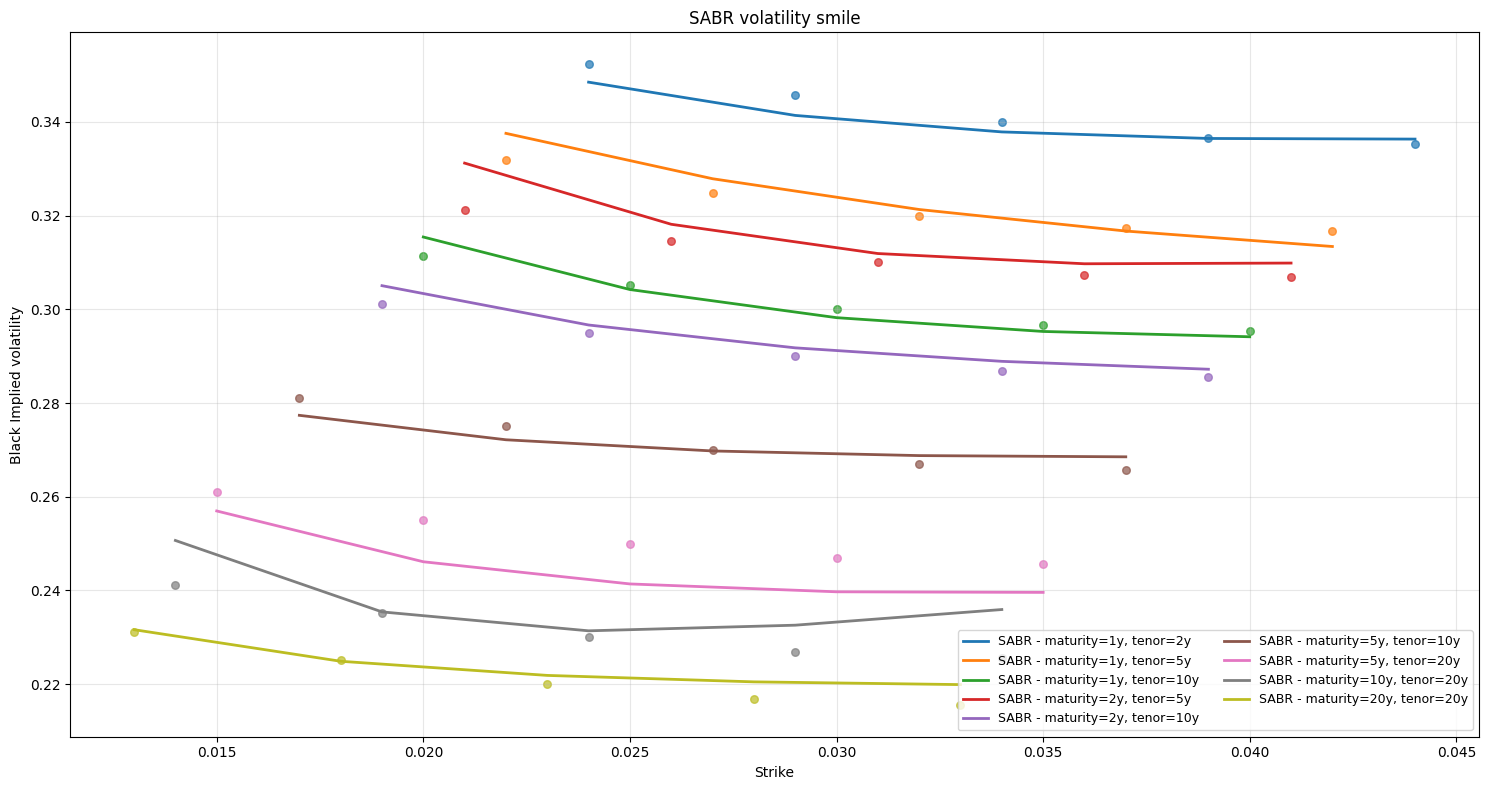

=== Calibrated SABR parameters (to be used for pricing fixed-income instruments) ===

SABR_Ts_opt = np.array([
    1, 1, 1, 2, 2,
    5, 5, 10, 20 ])

SABR_Ts_swap = np.array([
    2, 5, 10, 5, 10,
    10, 20, 20, 20 ])

SABR_Fs = np.array([
    0.034, 0.032, 0.03, 0.031, 0.029,
    0.027, 0.025, 0.024, 0.023 ])

SABR_betas = np.array([
    0.5, 0.5, 0.5, 0.5, 0.5,
    0.5, 0.5, 0.5, 0.5 ])

SABR_alphas = np.array([
    0.06154140717168879, 0.057071546680816286, 0.051160399582910174, 0.05346852731460168, 0.04902093277944416,
    0.04307792677874128, 0.037051267285865976, 0.03310485566252172, 0.03144874731296649 ])

SABR_rhos = np.array([
    0.4493562009437681, 0.44719999773015984, 0.3577735318263683, 0.3096598602549026, 0.498642208875981,
    0.6282077688589468, 0.4280776427827995, 0.3772159442491239, 0.647636051071296 ])

SABR_nus = np.array([
    0.3062433068794603, 0.204066836902525, 0.2752302469010509, 0.34577994104888926, 0.20677061046914622,
    0.18839548836836842, 0.2138212047

In [572]:
if __name__ == "__main__":
    main()